In [26]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import hopsworks

import warnings
warnings.filterwarnings("ignore")

### <span style='color:#ff5f27'> Imports

# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

In [27]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip any parent directories to add the root_dir to the PYTHON_PATH 
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('fingrid',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Added the following directory to the PYTHONPATH: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book
HopsworksSettings initialized!


## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [28]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store()

2026-01-02 19:56:16,145 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-02 19:56:16,158 INFO: Initializing external client
2026-01-02 19:56:16,160 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-02 19:56:17,940 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286359


In [29]:
# Retrieve feature groups
energy_fg = fs.get_feature_group(
    name='energy_consumption',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_finland',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> Feature View Creation and Retrieving </span>

In [30]:
# Select features for training data (no lag features - matching inference)
selected_features = energy_fg.select([
    'consumption_mw', 'date',
    'year', 'month', 'day', 'hour',
    'day_of_week', 'is_weekend', 'week_of_year'
]).join(weather_fg.select_features(), on=['country'])

print("Selected features: temporal + weather (no lags)")

2026-01-02 19:56:20,051 INFO: Using ['temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation'] from feature group `weather_finland` as features for the query. To include primary key and event time use `select_all`.
Selected features: temporal + weather (no lags)


In [31]:
feature_view = fs.get_or_create_feature_view(
    name='energy_consumption_fv',
    description="Temporal and weather features with energy consumption as target (no lag features)",
    version=1,  # Increment version since features changed
    labels=['consumption_mw'],
    query=selected_features,
)

## <span style="color:#ff5f27;">Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [32]:
start_date_test_data = "2025-12-15"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [33]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.19s) 


In [34]:
X_train

,date,year,month,day,hour,day_of_week,is_weekend,week_of_year,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation
0,2024-01-02 20:43:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.0,41.666667,1021.533333,0.0
1,2024-01-02 20:46:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.0,41.666667,1021.533333,0.0
2,2024-01-02 20:49:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.0,41.666667,1021.533333,0.0
3,2024-01-02 20:52:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.0,41.666667,1021.533333,0.0
4,2024-01-02 20:55:00+00:00,2024,1,2,20,1,0,1,-18.233333,0.0,65.0,19.533333,33.0,41.666667,1021.533333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374489,2025-12-14 23:45:00+00:00,2025,12,14,23,6,1,50,2.666667,1.7,100.0,21.900000,34.9,199.666667,1003.533333,0.0
374490,2025-12-14 23:48:00+00:00,2025,12,14,23,6,1,50,2.666667,1.7,100.0,21.900000,34.9,199.666667,1003.533333,0.0
374491,2025-12-14 23:51:00+00:00,2025,12,14,23,6,1,50,2.666667,1.7,100.0,21.900000,34.9,199.666667,1003.533333,0.0
374492,2025-12-14 23:54:00+00:00,2025,12,14,23,6,1,50,2.666667,1.7,100.0,21.900000,34.9,199.666667,1003.533333,0.0


In [35]:
y_train

,consumption_mw
0,14400.0
1,14366.0
2,14331.0
3,14277.0
4,14385.0
...,...
374489,10995.0
374490,10953.0
374491,10946.0
374492,10941.0


In [36]:
# Drop date column if it exists
columns_to_drop = [col for col in ['date', 'country'] if col in X_train.columns]
X_features = X_train.drop(columns=columns_to_drop)
X_test_features = X_test.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining features: {list(X_features.columns)}")

Dropped columns: ['date']
Remaining features: ['year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation']


## <span style="color:#ff5f27;">Add Cyclic Features for Temporal Variables</span>

Convert month, hour, and day_of_week to cyclic features using sine/cosine encoding. This ensures the model understands that December (12) is close to January (1), hour 23 is close to hour 0, etc.

In [37]:
# Add cyclic encoding for month (12 months in a year)
X_features['month_sin'] = np.sin(2 * np.pi * X_features['month'] / 12)
X_features['month_cos'] = np.cos(2 * np.pi * X_features['month'] / 12)
X_test_features['month_sin'] = np.sin(2 * np.pi * X_test_features['month'] / 12)
X_test_features['month_cos'] = np.cos(2 * np.pi * X_test_features['month'] / 12)

# Add cyclic encoding for hour (24 hours in a day)
X_features['hour_sin'] = np.sin(2 * np.pi * X_features['hour'] / 24)
X_features['hour_cos'] = np.cos(2 * np.pi * X_features['hour'] / 24)
X_test_features['hour_sin'] = np.sin(2 * np.pi * X_test_features['hour'] / 24)
X_test_features['hour_cos'] = np.cos(2 * np.pi * X_test_features['hour'] / 24)

# Add cyclic encoding for day_of_week (7 days in a week)
X_features['day_of_week_sin'] = np.sin(2 * np.pi * X_features['day_of_week'] / 7)
X_features['day_of_week_cos'] = np.cos(2 * np.pi * X_features['day_of_week'] / 7)
X_test_features['day_of_week_sin'] = np.sin(2 * np.pi * X_test_features['day_of_week'] / 7)
X_test_features['day_of_week_cos'] = np.cos(2 * np.pi * X_test_features['day_of_week'] / 7)

# Drop the original cyclic features to avoid confusion
X_features = X_features.drop(columns=['month', 'hour', 'day_of_week'])
X_test_features = X_test_features.drop(columns=['month', 'hour', 'day_of_week'])

print("Added cyclic features and dropped original month, hour, day_of_week")
print(f"New feature count: {len(X_features.columns)}")
print(f"Features: {list(X_features.columns)}")

Added cyclic features and dropped original month, hour, day_of_week
New feature count: 18
Features: ['year', 'day', 'is_weekend', 'week_of_year', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=3)`.

---

## <span style="color:#ff5f27;">Modeling</span>

We will train a regression model to predict energy consumption using our weather and temporal features

In [38]:
# Handle any missing values by filling with forward fill then backward fill
X_features = X_features.ffill().bfill()
X_test_features = X_test_features.ffill().bfill()

# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    random_state=42
)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [39]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating metrics
mae = mean_absolute_error(y_test.iloc[:,0], y_pred)
print("MAE:", mae)

mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R²:", r2)

MAE: 521.4013006116021
MSE: 489939.6234580936
RMSE: 699.9568725700846
R²: 0.6300265678653029


In [40]:
# Create dataframe with predictions and dates
df = y_test.copy()
df['predicted_consumption'] = y_pred
df['date'] = X_test['date'].values
df = df.sort_values(by=['date'])
df.head()

,consumption_mw,predicted_consumption,date
374494,10890.0,10013.235352,2025-12-15 00:00:00+00:00
374495,10864.0,10013.235352,2025-12-15 00:03:00+00:00
374496,10871.0,10013.235352,2025-12-15 00:06:00+00:00
374497,10877.0,10013.235352,2025-12-15 00:09:00+00:00
374498,10912.0,10013.235352,2025-12-15 00:12:00+00:00


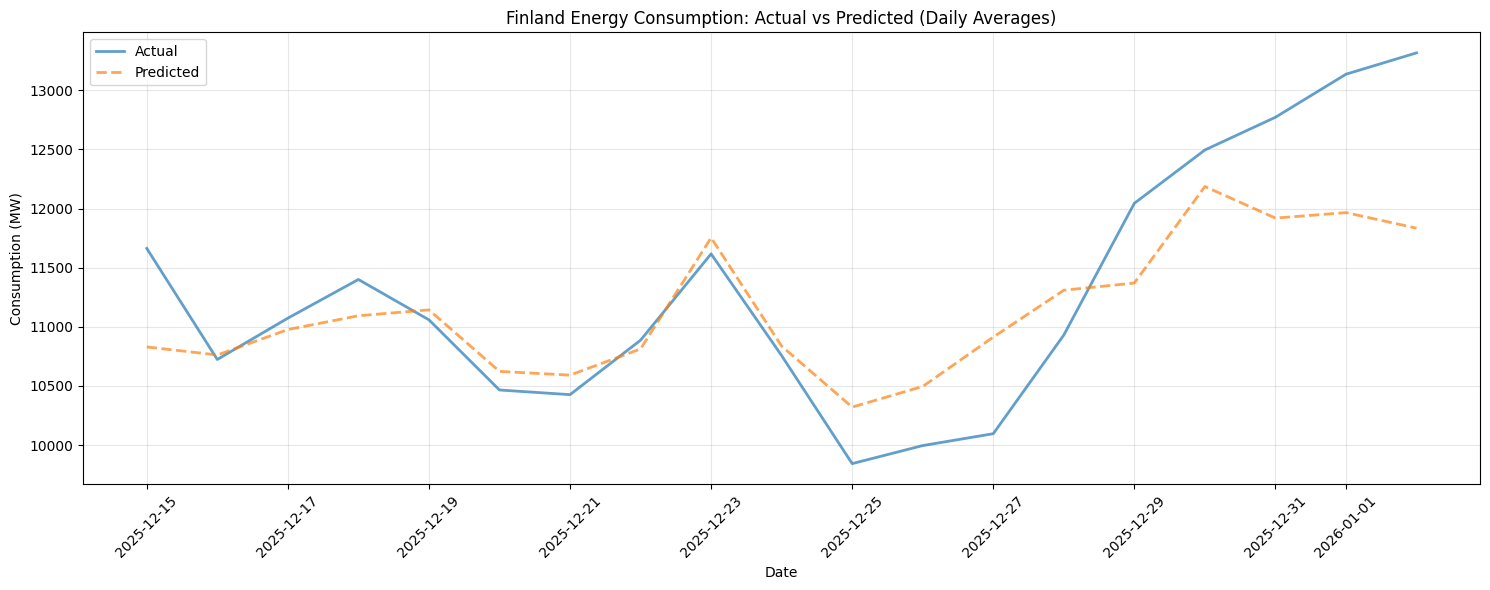

Original samples: 8980, Daily averages shown: 19
Plot saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/docs/fingrid/assets/img/energy_consumption_predictions.png


In [ ]:
# Plot predictions vs actual (resampled to daily averages for clarity)
# Resample to daily averages to make the plot readable
df['date'] = pd.to_datetime(df['date'])
df_daily = df.set_index('date').resample('D').mean().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(df_daily['date'], df_daily['consumption_mw'], label='Actual', linewidth=2, alpha=0.7)
plt.plot(df_daily['date'], df_daily['predicted_consumption'], label='Predicted', linewidth=2, alpha=0.7, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.title('Finland Energy Consumption: Actual vs Predicted (Daily Averages)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plot_path = f"{root_dir}/docs/fingrid/assets/img/energy_consumption_predictions.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Original samples: {len(df)}, Daily averages shown: {len(df_daily)}")
print(f"Plot saved to: {plot_path}")

In [42]:
# Investigate the drop between samples 6000-8000
print(f"Total test samples: {len(y_test)}")
print(f"\nTest set date range:")
print(f"  Start: {X_test['date'].min()}")
print(f"  End: {X_test['date'].max()}")

if len(y_test) > 8000:
    print(f"\nDates around the drop (samples 5900-6100):")
    print(X_test.iloc[5900:6100:20][['date']])
    
    print(f"\nDates around sample 7000:")
    print(X_test.iloc[6900:7100:20][['date']])
    
    print(f"\nConsumption values around the drop:")
    print(f"  Sample 6000: {y_test.iloc[6000, 0]:.2f} MW")
    print(f"  Sample 7000: {y_test.iloc[7000, 0]:.2f} MW")
    print(f"  Sample 8000: {y_test.iloc[8000, 0]:.2f} MW")
else:
    print(f"\nTest set only has {len(y_test)} samples, not 8000+")
    print("The drop you're seeing might be in the full dataset visualization")

Total test samples: 8980

Test set date range:
  Start: 2025-12-15 00:00:00+00:00
  End: 2026-01-02 18:45:00+00:00

Dates around the drop (samples 5900-6100):
                             date
380394  2025-12-27 07:12:00+00:00
380414  2025-12-27 08:12:00+00:00
380434  2025-12-27 09:12:00+00:00
380454  2025-12-27 10:12:00+00:00
380474  2025-12-27 11:12:00+00:00
380494  2025-12-27 12:12:00+00:00
380514  2025-12-27 13:12:00+00:00
380534  2025-12-27 14:12:00+00:00
380554  2025-12-27 15:12:00+00:00
380574  2025-12-27 16:12:00+00:00

Dates around sample 7000:
                             date
381394  2025-12-29 09:12:00+00:00
381414  2025-12-29 10:12:00+00:00
381434  2025-12-29 11:12:00+00:00
381454  2025-12-29 12:12:00+00:00
381474  2025-12-29 13:12:00+00:00
381494  2025-12-29 14:12:00+00:00
381514  2025-12-29 15:12:00+00:00
381534  2025-12-29 16:12:00+00:00
381554  2025-12-29 17:12:00+00:00
381574  2025-12-29 18:12:00+00:00

Consumption values around the drop:
  Sample 6000: 10292.00 MW
  

In [43]:
# Detailed analysis of the prediction failure around New Year's
df['date'] = pd.to_datetime(df['date'])
df_sorted = df.sort_values('date')

# Focus on Dec 28 - Jan 1
new_years = df_sorted[df_sorted['date'] >= '2025-12-28']

print("New Year's Period Analysis (Dec 28 - Jan 1):")
print("=" * 80)
print(f"\nActual consumption:")
print(f"  Min: {new_years['consumption_mw'].min():.0f} MW")
print(f"  Max: {new_years['consumption_mw'].max():.0f} MW")
print(f"  Mean: {new_years['consumption_mw'].mean():.0f} MW")

print(f"\nPredicted consumption:")
print(f"  Min: {new_years['predicted_consumption'].min():.0f} MW")
print(f"  Max: {new_years['predicted_consumption'].max():.0f} MW")
print(f"  Mean: {new_years['predicted_consumption'].mean():.0f} MW")

print(f"\nError:")
print(f"  MAE: {mean_absolute_error(new_years['consumption_mw'], new_years['predicted_consumption']):.0f} MW")
print(f"  Mean error: {(new_years['consumption_mw'] - new_years['predicted_consumption']).mean():.0f} MW")

# Sample some predictions
print("\nSample predictions (last 10 timestamps):")
print(df_sorted[['date', 'consumption_mw', 'predicted_consumption']].tail(10))

New Year's Period Analysis (Dec 28 - Jan 1):

Actual consumption:
  Min: 9718 MW
  Max: 13947 MW
  Mean: 12408 MW

Predicted consumption:
  Min: 9515 MW
  Max: 12969 MW
  Mean: 11759 MW

Error:
  MAE: 816 MW
  Mean error: 649 MW

Sample predictions (last 10 timestamps):
                            date  consumption_mw  predicted_consumption
383464 2026-01-02 18:18:00+00:00         13552.0           12002.981445
383465 2026-01-02 18:21:00+00:00         13472.0           12002.981445
383466 2026-01-02 18:24:00+00:00         13407.0           12002.981445
383467 2026-01-02 18:27:00+00:00         13378.0           12002.981445
383468 2026-01-02 18:30:00+00:00         13363.0           12002.981445
383469 2026-01-02 18:33:00+00:00         13296.0           12002.981445
383470 2026-01-02 18:36:00+00:00         13362.0           12002.981445
383471 2026-01-02 18:39:00+00:00         13341.0           12002.981445
383472 2026-01-02 18:42:00+00:00         13303.0           12002.981445
383473 20

In [44]:
# Check what features look like around New Year's
X_test_with_date = X_test.copy()
X_test_with_date['predicted'] = y_pred
X_test_with_date['actual'] = y_test.values

# Filter for New Year's period
new_years_features = X_test_with_date[X_test_with_date['date'] >= '2025-12-28'].sort_values('date')

print("Feature values during the prediction failure:")
print("=" * 80)
print("\nTemporal features:")
print(new_years_features[['date', 'month', 'day', 'hour', 'day_of_week', 'is_weekend']].describe())

# Check if weather features exist and show them
weather_cols = [col for col in new_years_features.columns if any(w in col.lower() for w in ['temp', 'wind', 'precip', 'pressure'])]
if weather_cols:
    print("\nWeather features statistics:")
    print(new_years_features[weather_cols].describe())
    
print("\nFirst few rows of New Year's period:")
display_cols = ['date', 'hour', 'day', 'actual', 'predicted'] + weather_cols[:3]
print(new_years_features[display_cols].head(20))

Feature values during the prediction failure:

Temporal features:
             month          day         hour  day_of_week   is_weekend
count  2744.000000  2744.000000  2744.000000  2744.000000  2744.000000
mean      8.692784    21.068149    11.015306     2.612974     0.174927
std       5.044896    12.898582     6.724389     2.002639     0.379974
min       1.000000     1.000000     0.000000     0.000000     0.000000
25%       1.000000     2.000000     5.000000     1.000000     0.000000
50%      12.000000    29.000000    11.000000     2.000000     0.000000
75%      12.000000    30.000000    17.000000     4.000000     0.000000
max      12.000000    31.000000    23.000000     6.000000     1.000000

Weather features statistics:
       temperature_2m  precipitation  wind_speed_10m  wind_speed_100m  \
count     2744.000000    2744.000000     2744.000000      2744.000000   
mean        -5.326701       0.122741       22.967128        34.402952   
std          4.592160       0.218453        9.

---

## <span style="color:#ff5f27;">Feature Importance Analysis</span>

In [45]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_features.columns,
    'importance': xgb_regressor.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
feature_importance.head(15)

Top 15 Most Important Features:


,feature,importance
13,month_cos,0.447255
4,temperature_2m,0.307900
12,month_sin,0.062301
15,hour_cos,0.044220
2,is_weekend,0.031217
0,year,0.029981
3,week_of_year,0.027276
1,day,0.007679
7,wind_speed_10m,0.006376
16,day_of_week_sin,0.005506


In [46]:
# Check correlation between features and target (using cleaned features)
correlations = X_features.corrwith(y_train.iloc[:, 0]).abs().sort_values(ascending=False)
print("Top 20 features by correlation with consumption:")
print(correlations.head(20))

Top 20 features by correlation with consumption:
temperature_2m         0.816990
month_cos              0.710225
month_sin              0.462365
week_of_year           0.377601
cloud_cover            0.265691
shortwave_radiation    0.256437
wind_speed_100m        0.231913
hour_cos               0.228349
wind_speed_10m         0.218896
is_weekend             0.102655
day_of_week_sin        0.078091
surface_pressure       0.066434
day                    0.064539
wind_direction_10m     0.058036
day_of_week_cos        0.047471
precipitation          0.011501
year                   0.004473
hour_sin               0.003602
dtype: float64


In [47]:
# Check all features and their importance
print("All features in the model:")
print(feature_importance)
print(f"\nTotal features: {len(feature_importance)}")

# Identify weather features (assuming they contain 'temp', 'wind', 'precip', 'pressure', 'humidity')
weather_keywords = ['temp', 'wind', 'precip', 'pressure', 'humidity', 'weather']
weather_features = feature_importance[feature_importance['feature'].str.contains('|'.join(weather_keywords), case=False)]
print(f"\nWeather features found: {len(weather_features)}")
if len(weather_features) > 0:
    print("\nWeather feature importance:")
    print(weather_features)

All features in the model:
                feature  importance
13            month_cos    0.447255
4        temperature_2m    0.307900
12            month_sin    0.062301
15             hour_cos    0.044220
2            is_weekend    0.031217
0                  year    0.029981
3          week_of_year    0.027276
1                   day    0.007679
7        wind_speed_10m    0.006376
16      day_of_week_sin    0.005506
17      day_of_week_cos    0.005117
10     surface_pressure    0.004949
8       wind_speed_100m    0.004877
11  shortwave_radiation    0.004286
5         precipitation    0.003652
9    wind_direction_10m    0.002795
14             hour_sin    0.002348
6           cloud_cover    0.002266

Total features: 18

Weather features found: 6

Weather feature importance:
               feature  importance
4       temperature_2m    0.307900
7       wind_speed_10m    0.006376
10    surface_pressure    0.004949
8      wind_speed_100m    0.004877
5        precipitation    0.003652
9  

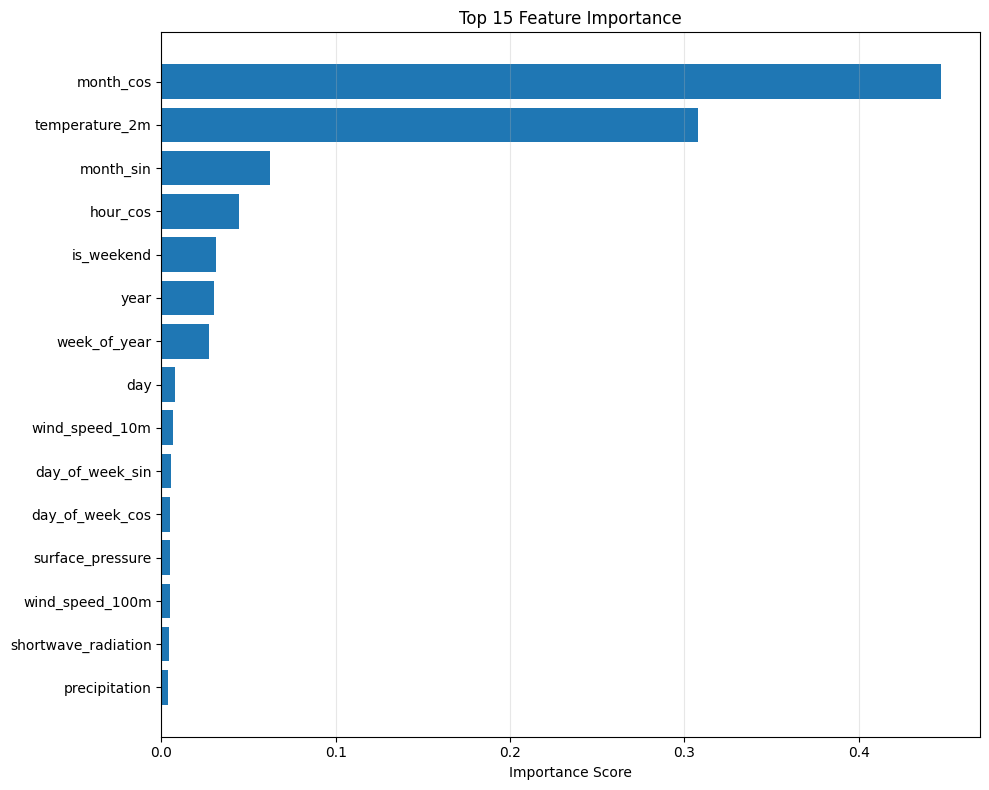

In [48]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['importance'].values)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

---

## <span style="color:#ff5f27;">Register Model to Hopsworks</span>

In [49]:
# Get model registry
mr = project.get_model_registry()

# Create model schema (input/output)
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Register model
energy_model = mr.python.create_model(
    name="energy_consumption_predictor",
    metrics={
        "mae": float(mae),
        "mse": float(mse),
        "rmse": float(rmse),
        "r2": float(r2)
    },
    description="XGBoost model for Finland energy consumption forecasting with weather features",
    input_example=X_train.sample(n=5),
    model_schema=model_schema
)

# Save model to registry
import os
model_dir = "energy_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
import joblib
joblib.dump(xgb_regressor, f"{model_dir}/energy_consumption_predictor.pkl")

energy_model.save(model_dir)
print(f"Model registered successfully!")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\energy_model/energy_consumption_…

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\input_example.json: 0.000%|     …

Uploading c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid\notebooks\model_schema.json: 0.000%|      …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286359/models/energy_consumption_predictor/14
Model registered successfully!
